In [1]:
from tsutils import get_jena, WindowGenerator

# Split Data

In [2]:
df = get_jena()

We will use a 70%, 20%, 10% train/validation/test split.

In [3]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# num_features = df.shape[1]

In [4]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [9]:
w = WindowGenerator(14, 1, 7, train_df, val_df, test_df, ['T (degC)'])

In [10]:
w

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [20]
Label column name(s): ['T (degC)']

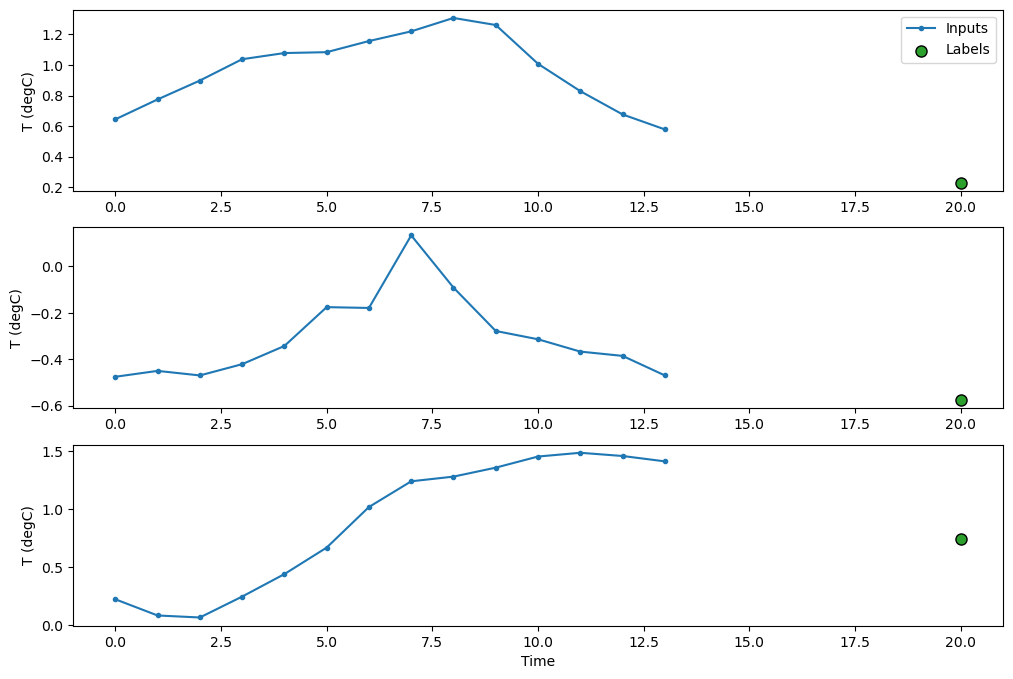

In [11]:
w.plot('T (degC)')